# Logistic Regression

Colab link: https://colab.research.google.com/notebooks/mlcc/logistic_regression.ipynb

## Frame the Problem as Binary Classification

The target of our dataset is `median_house_value` which is a numeric (continuous-valued) feature. We can create a boolean label by applying a threshold to this continuous value.

Given features describing a city block, we wish to predict if it is a high-cost city block. To prepare the targets for train and eval data, we define a classification threshold of the 75%-ile for median house value (a value of approximately 265000). All house values above the threshold are labeled `1`, and all others are labeled `0`.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')

chdf = chdf.reindex(np.random.permutation(chdf.index))

Note how the code below is slightly different from the previous exercises. Instead of using `median_house_value` as target, we create a new binary target, `median_house_value_is_high`.

In [0]:
# Preprocessing the features:
def preprocess_features(df):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = df[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]

  # print mean for each pd column:
  # print(selected_features.mean())
  # print(selected_features.std())

  processed_features = selected_features.copy()
  # Create a synthetic feature:
  processed_features['rooms_per_person'] = df['total_rooms'] / df['population']

  # Scaling the features:
  processed_features -= processed_features.mean()
  processed_features /= processed_features.std()

  return processed_features

In [0]:
# Preprocessing the labels:
def preprocess_targets(df):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()  # just to initialise the pd dataframe
  # Scale the target to be in units of thousands of dollars.
  # output_targets['median_house_value'] = df['median_house_value'] / 1000.0
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets['median_house_value_is_high'] = df['median_house_value'].apply(lambda val : 1 if val>265000 else 0)
  # alternative:
  # output_targets['median_house_value_is_high'] = (df['median_house_value']>265000).astype(float)  # astype(float) converts the boolean (False, True) to (0, 1)

  return output_targets


In [0]:
def TrainValTestDataSplit(feat_df, targ_df, train_percentage, val_percentage, test_percentage):

  # Data reshuffled randomly, just in case it hasn't been done yet:
  my_index = np.random.permutation(feat_df.index)
  feat_df = feat_df.reindex(my_index)
  targ_df = targ_df.reindex(my_index)

  # Training, Validation and Test dataset sizes:
  m_train = int(train_percentage*feat_df.shape[0])
  m_test = int(test_percentage*feat_df.shape[0])
  m_val = feat_df.shape[0] - m_train - m_test


  # Splitting DF into training and validation sets:
  training_examples = feat_df.head(m_train)
  training_targets = targ_df.head(m_train)
 
  validation_examples = feat_df.iloc[m_train:m_train+m_val] 
  validation_targets = targ_df.iloc[m_train:m_train+m_val]

  test_examples = feat_df.tail(m_test)  # we take the last examples using the tail command
  test_targets = targ_df.tail(m_test)

  return training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets


In [0]:
# Loading the data:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')
chdf = chdf.reindex(np.random.permutation(chdf.index))


# Processing the data:
pchdf = preprocess_features(chdf)  # def preprocess_features
ochdf = preprocess_targets(chdf)

print(pchdf.head())
print(ochdf.head())


# Chosen features:
# chosen_features = ['households', 'longitude', 'latitude', 'housing_median_age', 'median_income', 'rooms_per_person']
# pchdf = pchdf[chosen_features]


# Binning 'Latitude' feature:   # bucketised in feature columns
# pchdf['latitude bin 1'] = 0.0
# pchdf['latitude bin 2'] = 0.0
# pchdf['latitude bin 3'] = 0.0
# pchdf['latitude bin 4'] = 0.0
# pchdf['latitude bin 5'] = 0.0

# pchdf['latitude bin 1'].loc[pchdf['latitude']<-1] = 1.0
# pchdf['latitude bin 2'].loc[(pchdf.latitude>=-1) & (pchdf['latitude']<0)] = 1.0
# pchdf['latitude bin 3'].loc[(pchdf['latitude']>=0) & (pchdf.latitude<1)] = 1.0
# pchdf['latitude bin 4'].loc[(pchdf.latitude>=1) & (pchdf.latitude<2)] = 1.0
# pchdf['latitude bin 5'].loc[pchdf['latitude']>=2] = 1.0
# pchdf = BinFeature(pchdf, 'latitude', [-2, 3])   # def BinFeature

# display.display(pchdf.head())


# Splitting the dataframe (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.25
test_percentage = 0.0

[training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets] = TrainValTestDataSplit(pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit


# Describing the different data sets:
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

       latitude  longitude  ...  median_income  rooms_per_person
5358       -0.7        0.7  ...           -0.6              -0.6
3918       -0.7        0.8  ...           -0.2              -0.8
16567       1.3       -1.6  ...           -0.2               0.2
16378       1.1       -1.5  ...            2.2               0.7
5213       -0.9        0.7  ...            0.4               0.5

[5 rows x 9 columns]
       median_house_value_is_high
5358                            0
3918                            0
16567                           0
16378                           1
5213                            1
Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.4,-2.4,-2.2,-1.2,-1.3,-1.2,-1.3,-1.8,-1.7
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,0.0,-0.2,-0.3,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.3,0.3,0.5,0.3
max,3.0,2.6,1.9,16.2,14.0,23.6,14.5,5.8,45.5


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0,4250.0
mean,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.4,-2.3,-2.1,-1.2,-1.3,-1.2,-1.3,-1.8,-1.6
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,0.0,-0.2,-0.3,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.2,0.3,0.4,0.3
max,3.0,2.5,1.9,10.3,10.2,29.8,11.1,5.8,42.8


Test examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,nan,nan,nan,nan,nan,nan,nan,nan,nan
std,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,nan,nan,nan,nan,nan,nan,nan,nan,nan
25%,nan,nan,nan,nan,nan,nan,nan,nan,nan
50%,nan,nan,nan,nan,nan,nan,nan,nan,nan
75%,nan,nan,nan,nan,nan,nan,nan,nan,nan
max,nan,nan,nan,nan,nan,nan,nan,nan,nan


Training targets summary:


,median_house_value_is_high
count,12750.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.8
max,1.0


Validation targets summary:


,median_house_value_is_high
count,4250.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Test targets summary:


,median_house_value_is_high
count,0.0
mean,nan
std,nan
min,nan
25%,nan
50%,nan
75%,nan
max,nan


# We try with Linear Regression first:

In [0]:
# Defining feature columns:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.

    Args:
      input_features: The names of the numerical input features to use.
    Returns:
      A set of feature columns
    """ 
    # return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])  
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])   # set is not needed

# print(construct_feature_columns(training_examples))


In [0]:
# Input function:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()  ## TF 1!!!

    return features, labels


In [0]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size=1, num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, batch_size=1, num_epochs=1, shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(training_predictions, training_targets) )
    validation_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(validation_predictions, validation_targets) )
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15, 6))
  plt.subplot(1,2,1)
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(training_predictions, training_targets.values, '.', label='training predicted vs reality' )
  plt.plot(validation_predictions, validation_targets.values, '.', label='validation predicted vs reality')
  plt.legend()
  plt.grid()
  plt.ylabel("targetss")
  plt.xlabel("predictions")
  plt.title("Predicted vs Targets")

  plt.show()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.42
  period 01 : 0.38
  period 02 : 0.37
  period 03 : 0.36
  period 04 : 0.36
  period 05 : 0.35
  period 06 : 0.35
  period 07 : 0.35
  period 08 : 0.35
  period 09 : 0.35
Model training finished.


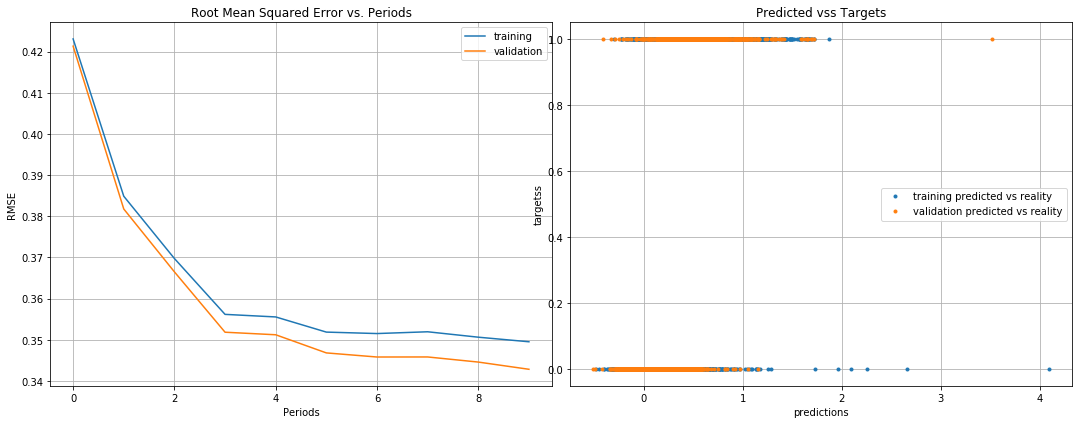

In [0]:
# Call the training model:
learning_rate = 0.001
steps = 500
batch_size = 5

linear_regression = train_linear_regressor_model(
    learning_rate=learning_rate,
    steps=steps,
    batch_size=batch_size,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

# Calculating the LogLoss

## Task 1: Can We Calculate LogLoss for These Predictions?

**Examine the predictions and decide whether or not we can use them to calculate LogLoss.**

`LinearRegressor` uses the L2 loss, which doesn't do a great job at penalizing misclassifications when the output is interpreted as a probability.  For example, there should be a huge difference whether a negative example is classified as positive with a probability of 0.9 vs 0.9999, but L2 loss doesn't strongly differentiate these cases.

In contrast, `LogLoss` penalizes these "confidence errors" much more heavily.  Remember, `LogLoss` is defined as:

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


But first, we'll need to obtain the prediction values. We could use `LinearRegressor.predict` to obtain these.

Given the predictions and the targets, can we calculate `LogLoss`?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


array([0.75920963, 0.46532613, 0.04795231, ..., 0.01117469, 0.00165032,
       0.731484  ], dtype=float32)

 LogLoss on Training set: nan
 LogLoss on Validation set: nan


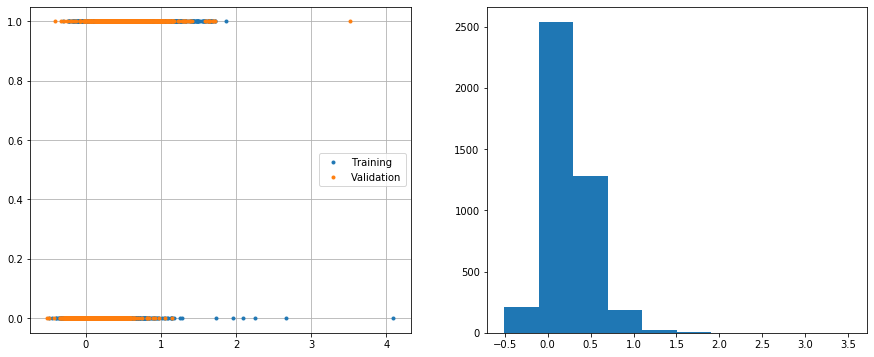

In [0]:
# Compute predictions:
predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size=1, num_epochs=1, shuffle=False)
training_predictions = linear_regression.predict(input_fn=predict_training_input_fn)
training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, batch_size=1, num_epochs=1, shuffle=False)
validation_predictions = linear_regression.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

# Compute LogLoss:
training_logloss = -np.sum( training_targets.values * np.log(training_predictions) + (1-training_targets.values) * np.log(1-training_predictions) )
# training_logloss = -np.dot( (training_targets.values).T, np.log(training_predictions) ) - np.dot( (1-training_targets.values).T , np.log(1-training_predictions) )
validation_logloss = -np.sum( validation_targets.values * np.log(validation_predictions) + (1-validation_targets.values) * np.log(1-validation_predictions) )
# validation_logloss = -np.dot( (validation_targets.values).T, np.log(validation_predictions) ) - np.dot( (1-validation_targets.values).T , np.log(1-validation_predictions) )

training_logloss = np.sum(training_targets.values * training_predictions)
training_logloss = np.sum(np.log(training_predictions))

display.display(training_predictions)

print(" LogLoss on Training set: %0.2f" % (training_logloss))
print(" LogLoss on Validation set: %0.2f" % (validation_logloss))

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(training_predictions, training_targets.values, '.', label='Training')
plt.plot(validation_predictions, validation_targets.values, '.', label='Validation')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.hist(validation_predictions)
plt.show()

## Task 2: Train a Logistic Regression Model and Calculate LogLoss on the Validation Set

To use logistic regression, simply use [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) instead of `LinearRegressor`.

**NOTE**: When running `train()` and `predict()` on a `LinearClassifier` model, you can access the real-valued predicted probabilities via the `"probabilities"` key in the returned dict—e.g., `predictions["probabilities"]`. Sklearn's [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) function is handy for calculating LogLoss using these probabilities.


In [0]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets, batch_size=1, num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, batch_size=1, num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.  ## Linear Classifier instead of Regression!!
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # Computing the LogLoss
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15, 6))
  plt.subplot(1,2,1)
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  # Get the predictions using the probabilities: if prob>=0.5 -> y_pre=1; if prb<0.5 -> y_pred=0
  training_predictions = np.array( list( map(lambda val : 1 if val>0.5 else 0, training_probabilities[:,1]) ) )   # if prob>0.5 -> 1; if prob<0.5 ->  0    # to get more than one column: training_probabilities[:,[0:5]]
  validation_predictions = np.array( list( map(lambda val : 1 if val>0.5 else 0, validation_probabilities[:,1]) ) )   # if prob>0.5 -> 1; if prob<0.5 ->  0

  plt.subplot(1,2,2)
  plt.plot(training_predictions, training_targets.values, '.', label='training predicted vs reality' )
  plt.plot(validation_predictions, validation_targets.values, '.', label='validation predicted vs reality')
  plt.legend()
  plt.grid()
  plt.ylabel("targets")
  plt.xlabel("predictions")
  plt.title("Predicted vs Targets")

  plt.show()


  return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.43
  period 01 : 0.38
  period 02 : 0.36
  period 03 : 0.35
  period 04 : 0.35
  period 05 : 0.34
  period 06 : 0.34
  period 07 : 0.34
  period 08 : 0.33
  period 09 : 0.33
Model training finished.


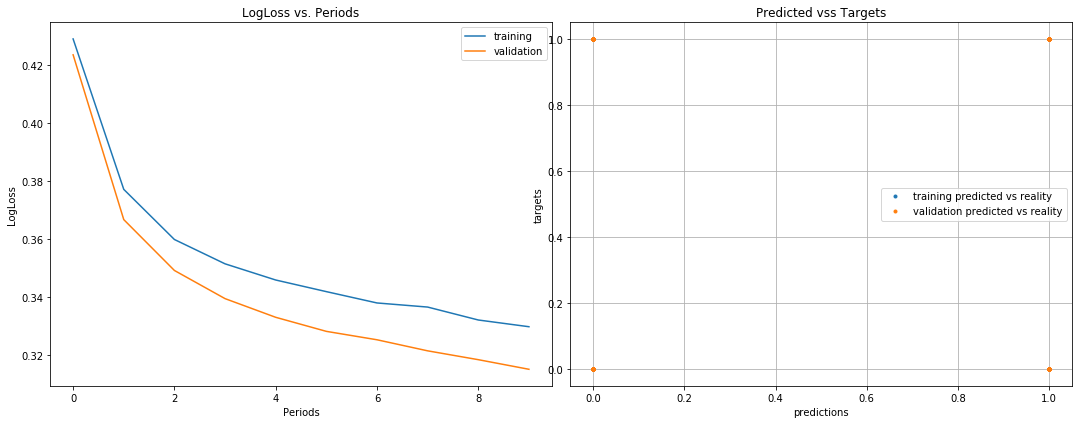

In [0]:
# Call the training model:
learning_rate = 0.007
steps = 600
batch_size = 20

linear_classification = train_linear_classifier_model(
    learning_rate=learning_rate,
    steps=steps,
    batch_size=batch_size,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 3: Calculate Accuracy and plot a ROC Curve for the Validation Set

A few of the metrics useful for classification are the model [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the area under the ROC curve (AUC). We'll examine these metrics.

`LinearClassifier.evaluate` calculates useful metrics like accuracy and AUC.

In [0]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, batch_size=1, num_epochs=1, shuffle=False)

# Getting the metrics from the classification model
validation_metrics = linear_classification.evaluate(input_fn=predict_validation_input_fn)

# AUC: Area under the ROC. The closer to 1, the better.
print('AUC on the validation set: %0.3f' %validation_metrics['auc'])
print('Accuracy on the validation set: %0.3f' %validation_metrics['accuracy'])

AUC on the validation set: 0.910
Accuracy on the validation set: 0.871


[0 1 0 0 0]
(4250, 1)
F1-score: 0.704



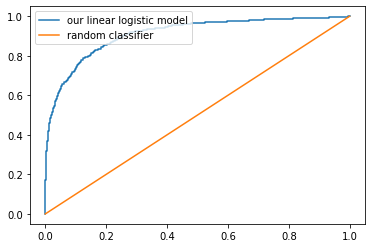


Classification report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      3191
           1       0.82      0.62      0.70      1059

    accuracy                           0.87      4250
   macro avg       0.85      0.79      0.81      4250
weighted avg       0.87      0.87      0.86      4250



In [0]:
validation_probabilities = linear_classification.predict(input_fn=predict_validation_input_fn)

# Get just the probabilities for the positive class.  
#### the [1] (second column in probabilities) is important because it gets the probability for being 1. [0] (first column in probabilities) gets the probability of being 0!!!!!!
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

# Get the predictions using the probabilities: if prob>=0.5 -> y_pre=1; if prb<0.5 -> y_pred=0
## prob_to_pred_lam = lambda val : 1 if val>0.5 else 0
## validation_predictions = prob_to_pred_lam(validation_probabilities)
## validation_predictions = np.zeros(validation_probabilities.shape)
## for val in validation_probabilities:
##   if val > 0.5:
##     validation_predictions = 1.0
# Three alternatives to compute predictions (0,1) from probabilities:
validation_predictions = np.array( list( map(lambda val : 1 if val>0.5 else 0, validation_probabilities) ) )   # if prob>0.5 -> 1; if prob<0.5 ->  0
validation_predictions = (validation_probabilities>=0.5).astype(float)   # if prob>0.5 -> True -> float 1; if prob<0.5 -> False -> float 0   # this works too!
validation_predictions = np.array( [(1 if val>0.5 else 0) for val in validation_probabilities] )   # this works too!

# display.display(validation_probabilities[0:5])
print(validation_predictions[0:5])

# print(validation_probabilities.shape)
print(validation_targets.shape)


# F1-score = (2 * precision * recall) / (precision + recall), using the predictions:
f1score = metrics.f1_score(validation_targets, validation_predictions)
print('F1-score: %0.3f' %f1score)
print('')

# ROC curve, using the probabilities:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve( validation_targets, validation_probabilities )

# Plotting the ROC curve:
plt.plot(false_positive_rate, true_positive_rate, label='our linear logistic model')
plt.plot([0, 1], [0, 1], label='random classifier')
plt.legend(loc=2)
plt.show()
print('')

# Classification report
classification_report = metrics.classification_report(validation_targets, validation_predictions)
print('Classification report:')
print(classification_report)
